In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm

In [4]:
train_audio_path = "./data/train/audio/"

16000
16000


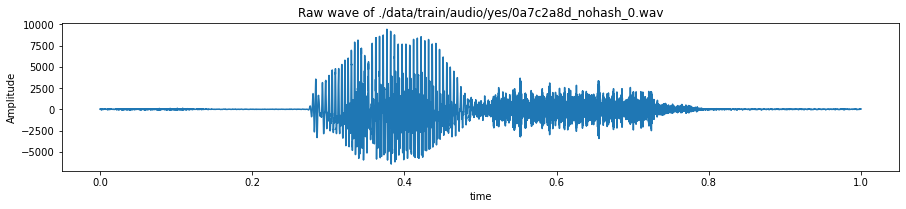

In [5]:
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Raw wave of ' + f'{str(train_audio_path) + filename}')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
print(sample_rate)
print(len(samples))

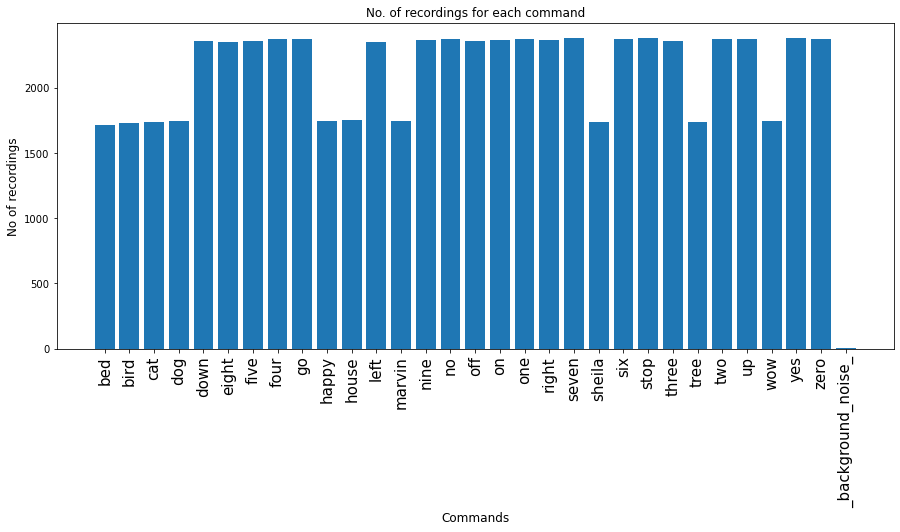

In [6]:
import os

labels = os.listdir(train_audio_path)
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(labels)), no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(np.arange(len(labels)), labels, fontsize=15, rotation=90)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
import librosa

def load_waves_and_labels(filepath, labels):
    all_wave, all_label = [], []
    for label in tqdm(labels):
        waves = [f for f in os.listdir(filepath + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
            samples = librosa.resample(samples, sample_rate, 8000)
            if (len(samples)==8000):
                all_wave.append(samples)
                all_label.append(label)
    return all_wave, all_label

In [9]:
train_audio_path = './data/train/audio/'
all_wave, all_label = load_waves_and_labels(train_audio_path, labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [15:22<00:00, 29.76s/it]


In [13]:
all_wave = np.array(all_wave).reshape(-1, 8000, 1)
all_wave.shape

(58252, 8000, 1)

In [14]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    Converts a class vector (integers) to binary class matrix.
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)
y_onehot = to_categorical(y, len(classes))

In [16]:
def compute_mfcc(data, n_mfcc, sr=16000):
    print('Compute MFCC, n_mfcc=' + str(n_mfcc), flush=True)
    all_mfcc = []
    for wav in tqdm(data):
        feature = librosa.feature.mfcc(wav.reshape(-1, ), 
                                       sr=sr, 
                                       n_mfcc=n_mfcc, 
                                       n_fft=int(sr*0.025),
                                       hop_length=int(sr*0.01))
        feature = feature.T
        feature = feature[:-1, :]
        all_mfcc.append(feature)
    return np.array(all_mfcc)

In [17]:
all_mfcc = compute_mfcc(all_wave, n_mfcc=20, sr=8000)

Compute MFCC, n_mfcc=20


  0%|                                                                                        | 0/58252 [00:00<?, ?it/s]C:\Users\Yang\anaconda3\envs\torch\lib\site-packages\librosa\filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|███████████████████████████████████████████████████████████████████████████| 58252/58252 [02:01<00:00, 480.70it/s]


In [18]:
all_mfcc.shape

(58252, 100, 20)

In [46]:
import torch
import torch.nn as nn

class StatsPool(nn.Module):

    def __init__(self, floor=1e-10, bessel=False):
        super(StatsPool, self).__init__()
        self.floor = floor
        self.bessel = bessel

    def forward(self, x):
        means = torch.mean(x, dim=1)
        _, t, _ = x.shape
        if self.bessel:
            t = t - 1
        residuals = x - means.unsqueeze(1)
        numerator = torch.sum(residuals**2, dim=1)
        stds = torch.sqrt(torch.clamp(numerator, min=self.floor)/t)
        x = torch.cat([means, stds], dim=1)
        return x


class TDNN(nn.Module):

    def __init__(
        self,
        input_dim=23,
        output_dim=512,
        context_size=5,
        stride=1,
        dilation=1,
        batch_norm=True,
        dropout_p=0.0,
        padding=0
    ):
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.padding = padding

        self.kernel = nn.Conv1d(self.input_dim,
                                self.output_dim,
                                self.context_size,
                                stride=self.stride,
                                padding=self.padding,
                                dilation=self.dilation)

        self.nonlinearity = nn.ReLU()
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        self.drop = nn.Dropout(p=self.dropout_p)

    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''
        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(
            self.input_dim, d)

        x = self.kernel(x.transpose(1, 2))
        x = self.nonlinearity(x)
        x = self.drop(x)

        if self.batch_norm:
            x = self.bn(x)
        return x.transpose(1, 2)
    
class XVectors(nn.Module):
    
    def __init__(
        self,
        dropout_p=0.0, 
        n_classes=30
    ):
        super(XVectors, self).__init__()
        self.tdnn1 = TDNN(input_dim=20, context_size=3, padding=math.floor(3/2))
        self.tdnn2 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.tdnn3 = TDNN(input_dim=512, output_dim=1500, context_size=1, padding=math.floor(1/2))
        self.tdnnres1 = TDNN(input_dim=512, context_size=5, padding=math.floor(5/2))
        self.tdnnres2 = TDNN(input_dim=512, context_size=5, padding=math.floor(5/2))
        self.tdnnres3 = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2))
        self.pool = StatsPool()
        self.linear1 = nn.Linear(3000, 512)
        self.linear2 = nn.Linear(512, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.nonlinearity = nn.ReLU()
        self.classifier = nn.Linear(512, n_classes)
        
    def forward(self, x):
        # Residual TDNN based Frame-level Feature Extractor
        x = self.tdnn1(x)
        x = self.tdnn2(x)
        x = self.tdnnres1(x) + x
        x = self.tdnnres2(x) + x
        x = self.tdnnres3(x) + x
        x = self.tdnn3(x)
        
        # Statistics Pooling
        x = self.pool(x)
        
        # DNN based Segment level Feature Extractor
        x = self.linear1(x)
        x = self.nonlinearity(self.dropout1(self.bn1(x)))
        x = self.linear2(x)
        x = self.nonlinearity(self.dropout2(self.bn2(x)))
        
        # Classifier
        x = self.classifier(x)
        
        return x

In [38]:
# Usual trick here is that if your stride is 1 an dilation is 1 and your kernel has an odd size, 
# you can set the padding to be floor(kernel_size/2).
# By doing so, you can ensure Conv1d retains the same shape

t_input = torch.from_numpy(all_mfcc[:10, :, :])
print(t_input.size())
t_output = TDNN(input_dim=20, context_size=3, padding=math.floor(3/2)).forward(t_arr)
print(t_output.size())
t_output = TDNN(input_dim=512, context_size=1, padding=math.floor(1/2)).forward(t_output)
print(t_output.size())
t_output = t_output + TDNN(input_dim=512, context_size=5, padding=math.floor(5/2)).forward(t_output)
print(t_output.size())
t_output = StatsPool().forward(t_output)
print(t_output.size())

torch.Size([10, 100, 20])
torch.Size([10, 100, 512])
torch.Size([10, 100, 512])
torch.Size([10, 100, 512])
torch.Size([10, 1024])


In [96]:
xvectors = XVectors()
out = xvectors(t_input)
out.size()

torch.Size([10, 30])

In [75]:
class SpeechDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index, :, :]
        y = self.y[index]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return [X, y]

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [87]:
# idx = list(range(len(all_mfcc)))
# np.random.shuffle(idx)
# all_mfcc_shuffle = all_mfcc[idx, :, :]
# y_shuffle = y[idx]

In [151]:
# X_train = all_mfcc_shuffle[:40000, :, :]
# y_train = y_shuffle[:40000]
# X_valid = all_mfcc_shuffle[40000:, :, :]
# y_valid = y_shuffle[40000:]

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(all_mfcc, y, test_size=0.3, random_state=914, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=914, stratify=y_valid)

In [174]:
train_dataset = SpeechDataset(X=X_train, y=y_train)
valid_dataset = SpeechDataset(X=X_valid, y=y_valid)
test_dataset = SpeechDataset(X=X_test, y=y_test)

In [175]:
batch_size = 16

train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
valid_dataloader = valid_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

In [176]:
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [16, 100, 20]
  y: [16]


In [183]:
from sklearn.metrics import accuracy_score, f1_score

class Trainer(object):
    
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):
        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0
        # Iterate over train batches
        for i, batch in enumerate(dataloader):
            # Step
            batch = [item.to(self.device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()
            z = self.model(inputs[0])
            J = self.loss_fn(z, targets)
            J.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)
        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                # Step
                batch = [item.to(self.device) for item in batch]
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs[0])
                J = self.loss_fn(z, y_true).item()
                # Cumulative Metrics
                loss += (J - loss) / (i + 1)
                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())
        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                # Forward pass with inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs[0])
                # Store outputs
                y_probs.extend(y_prob)
        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        self.train_losses, self.valid_losses = [], []
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            valid_loss, y_trues, y_probs = self.eval_step(dataloader=val_dataloader)
            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)
            y_preds = np.argmax(y_probs, axis=1)
            val_f1 = f1_score(y_trues, y_preds, average="weighted")
            self.scheduler.step(valid_loss)
            # Early stopping
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                best_model = self.model
                _patience = patience
            else:
                _patience -= 1
            if not _patience:
                print("Stopping early!")
                break
            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {valid_loss:.5f}, "
                f"val_f1: {val_f1:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [184]:
model = XVectors(dropout_p=0.1, n_classes=len(classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model.named_parameters)

<bound method Module.named_parameters of XVectors(
  (tdnn1): TDNN(
    (kernel): Conv1d(20, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (nonlinearity): ReLU()
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (tdnn2): TDNN(
    (kernel): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
    (nonlinearity): ReLU()
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (tdnn3): TDNN(
    (kernel): Conv1d(512, 1500, kernel_size=(1,), stride=(1,))
    (nonlinearity): ReLU()
    (bn): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (tdnnres1): TDNN(
    (kernel): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (nonlinearity): ReLU()
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [185]:
lr = 2e-4
num_epochs = 40
patience = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [186]:
trainer = Trainer(
    model=model, 
    device=device, 
    loss_fn=loss_fn,
    optimizer=optimizer, 
    scheduler=scheduler
)

In [187]:
best_model = trainer.train(num_epochs, patience, train_dataloader, valid_dataloader)

Epoch: 1 | train_loss: 0.82446, val_loss: 0.36659, val_f1: 0.90015, lr: 2.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.35392, val_loss: 0.29041, val_f1: 0.91906, lr: 2.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.24703, val_loss: 0.24642, val_f1: 0.93213, lr: 2.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.18833, val_loss: 0.23533, val_f1: 0.93772, lr: 2.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.14996, val_loss: 0.25875, val_f1: 0.93696, lr: 2.00E-04, _patience: 9
Epoch: 6 | train_loss: 0.12331, val_loss: 0.24712, val_f1: 0.94232, lr: 2.00E-04, _patience: 8
Epoch: 7 | train_loss: 0.10508, val_loss: 0.25144, val_f1: 0.94367, lr: 2.00E-04, _patience: 7
Epoch: 8 | train_loss: 0.08778, val_loss: 0.29882, val_f1: 0.94008, lr: 2.00E-04, _patience: 6
Epoch: 9 | train_loss: 0.07340, val_loss: 0.34874, val_f1: 0.93937, lr: 2.00E-04, _patience: 5
Epoch: 10 | train_loss: 0.06549, val_loss: 0.40627, val_f1: 0.94230, lr: 2.00E-05, _patience: 4
Epoch: 11 | train_loss: 0.03250, val_loss: 0.

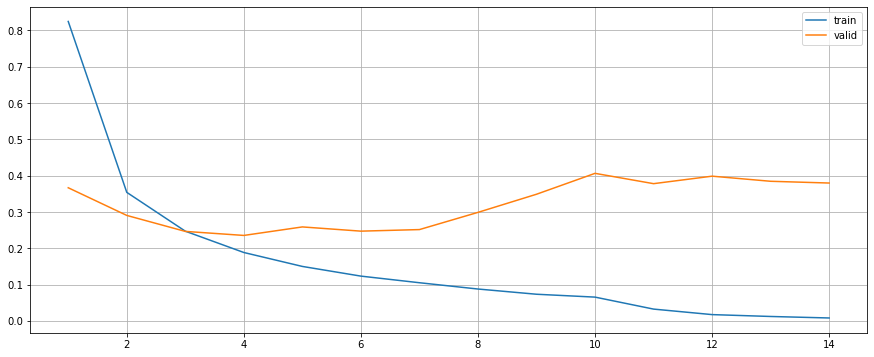

In [188]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label="train")
plt.plot(range(1, len(trainer.valid_losses)+1), trainer.valid_losses, label="valid")
plt.legend()
plt.grid()
plt.show()